In [1]:
%matplotlib inline

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pylab as pl
from IPython import display

from ParticleFilter.Tools import resample

In [3]:
Characterisation_Set = pickle.load(
    open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 
                                        'rb'))

def scale(X):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X.min())/(X.max() - X.min()), X.min(), X.max()

def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)

SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}
print(Current_min, Current_max)

-0.000520787 6.74372


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
save_network = "./Battery_Data/new_battery_cycles/Battery_RNN_GT_new_v1.mdl"

SoC mean: -8.131135726750027e-06

SoC std: 0.0002551068601502507

Voltage mean: 0.0033256651

Voltage std: 0.011334095

In [6]:
class RNNetwork(nn.Module):
    def __init__(self):
        super(RNNetwork, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        # SMC params
        self.f_std = torch.Tensor([0.0001])
        self.g_std = 0.001
        self.nu = torch.Tensor([1.0 / (self.g_std * np.sqrt(2 * np.pi))])

    def VoC(self, SoC):
        v_L = torch.Tensor([[-1.59614486]]).to(device)
        v_0 = torch.Tensor([[4.13646328]]).to(device)
        gamma = torch.Tensor([[0.63726463]]).to(device)
        alpha = torch.Tensor([[1.40174122]]).to(device)
        beta = torch.Tensor([[2.54478965]]).to(device)
        return v_L + (v_0 - v_L)*torch.exp(gamma*(SoC - 1)) + alpha*v_L*(SoC - 1) \
            + (1 - alpha)*v_L*(torch.exp(-beta) - torch.exp(-beta*torch.sqrt(SoC)))

    def forward(self, soc_init, current, voltage_measured):
        first = True
        voltage = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc_hist = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc = soc_init.to(device, torch.float)
        N = soc_init.shape[0]

        for t in range(current.shape[1]):

            # A prior estimate
            if first:
                I = torch.ones(N, 1) * current[0, t]
            else:
                I = torch.ones(N, 1) * current[0, t-1]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)
            V = self.VoC(soc) - I * Z

            # Predict SoC(t-1) -> SoC(t)
            soc = soc - I*V/Characterisation_Set['E_crit']
            # Add model uncertainty
            soc = soc + torch.normal(torch.ones([N, 1])*-8.131135726750027e-06, 
                                     torch.ones([N, 1]) * 0.0002551068601502507).to(device)

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            I = torch.ones(N, 1) * current[0, t]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # a Priori evidence
            V = self.VoC(soc) - I*Z

            #SMC

            W = self.nu * torch.exp(-0.5 * torch.pow((V.to("cpu") 
                                                      - voltage_measured[0, t]) / 0.011334095, 2.0))
            logW = torch.log(self.nu) - 0.5 * torch.pow((V.to("cpu") 
                                                         - voltage_measured[0, t]) / 0.011334095, 2.0)

            max_logW = logW.max()
            loss_W = torch.exp(logW - max_logW)

            # Resampling
            soc, W = resample(soc, loss_W)
            
            first = False

            voltage[:, t] = V[:, 0]
            soc_hist[:, t] = soc[:, 0]

        return voltage, soc_hist

In [7]:
batteryObserver = RNNetwork()
batteryObserver.load_state_dict(torch.load(save_network))
batteryObserver.to(device)

RNNetwork(
  (Z_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (Z_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (Z_p): Linear(in_features=512, out_features=1, bias=True)
)

In [8]:
voltage_sets = []
soc_sets = []
N = 100

with torch.no_grad():
    for i, set_dict in enumerate(Characterisation_Set['Sets']):
        state = torch.ones(N, 1) * 1.0
        voltage, soc_hist = batteryObserver(state, set_dict['Current'], set_dict['Voltage'])
        voltage_sets.append(voltage.numpy())
        soc_sets.append(soc_hist.numpy())

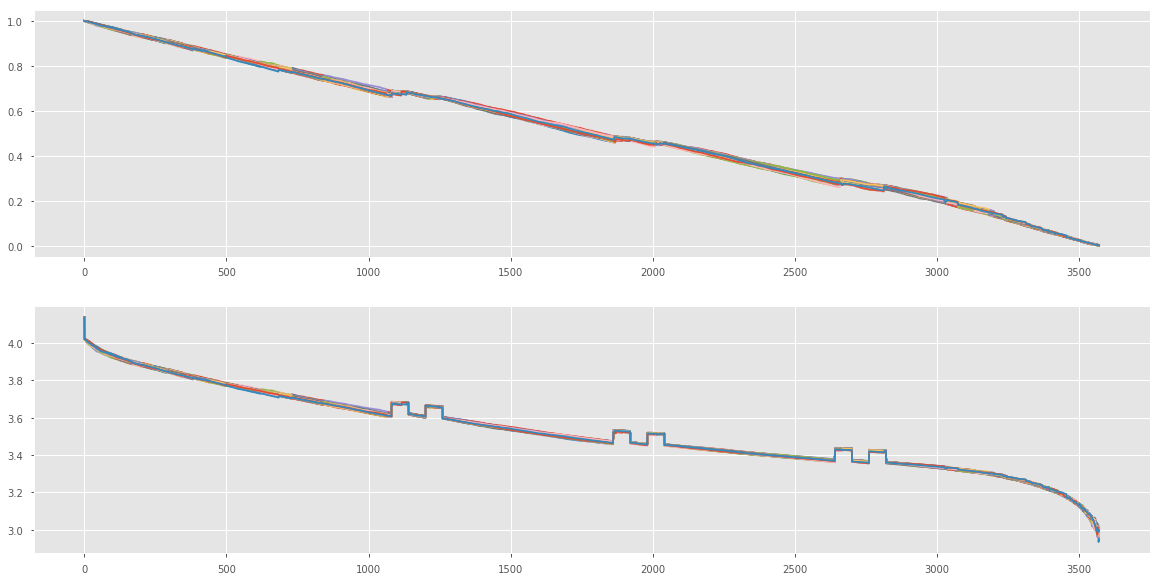

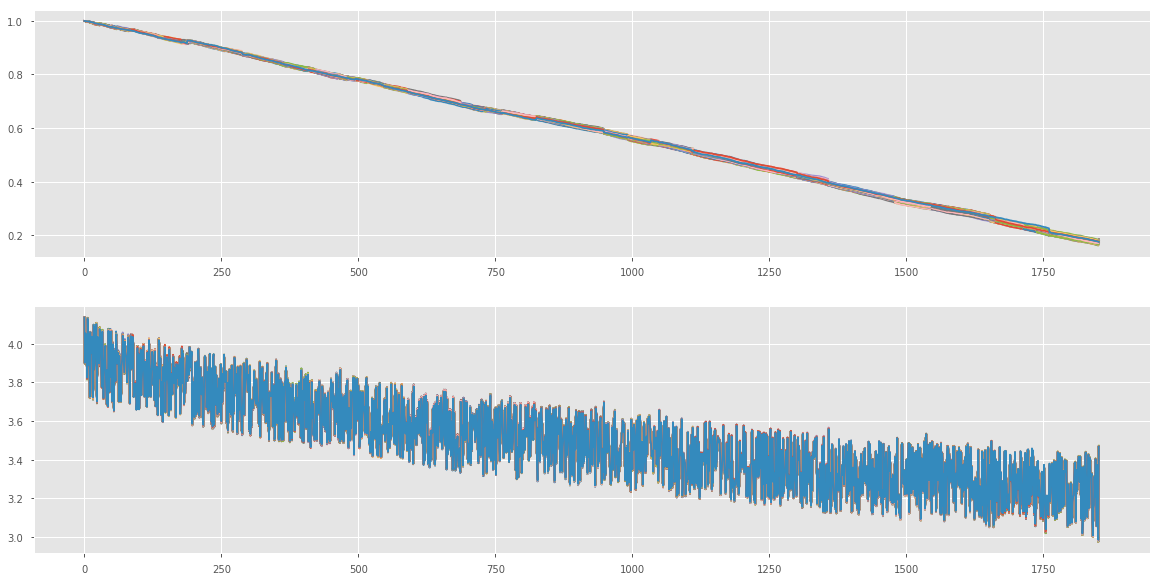

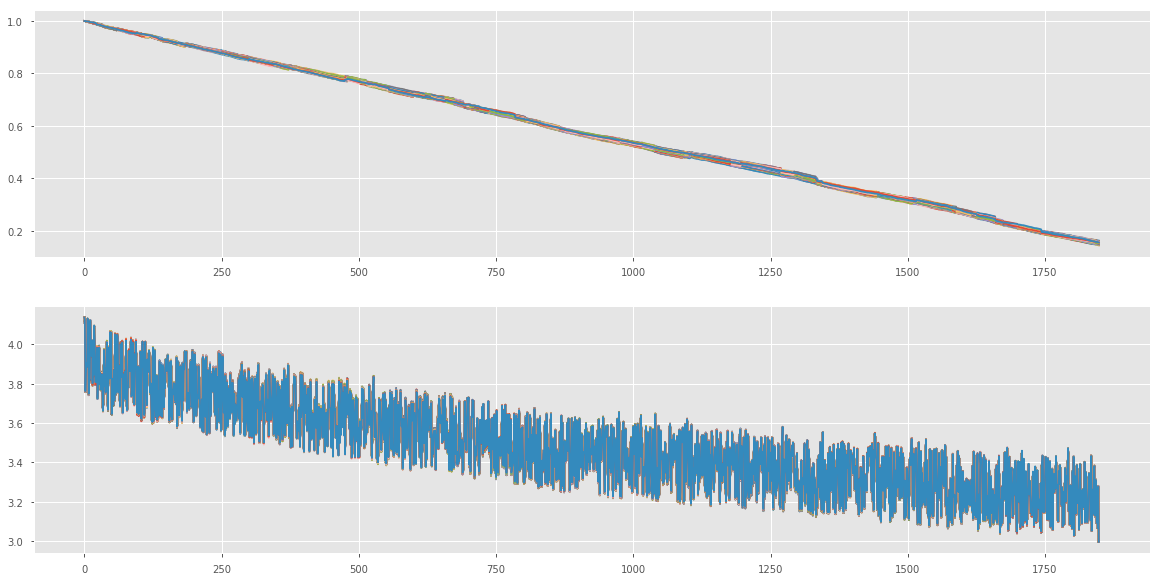

In [12]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
for soc, voltage in zip(soc_sets, voltage_sets):
    plt.figure()
    plt.subplot(211)
    plt.plot(soc.T)
    plt.subplot(212)
    plt.plot(voltage)
plt.show()